In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

In [28]:
import os

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping

Bu projede, veri işleme ve model oluşturma için gerekli kütüphaneler ve modüller içe aktarılmıştır:

- **os**: Dosya ve dizin işlemleri için.
- **pandas** ve **numpy**: Veri işleme ve analiz için.
- **tensorflow**: Derin öğrenme modeli oluşturmak için.
- **ImageDataGenerator**: Görüntüleri işlemek ve artırmak için.
- **matplotlib** ve **seaborn**: Görselleştirme için.
- **confusion_matrix**, **classification_report**: Model değerlendirme metrikleri.
- **EarlyStopping**: Eğitim sırasında erken durdurma işlemi için.

In [29]:
label = []
path = []
fish_dir = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

Bu hücrede, balık görüntüleri ve etiketleri veri çerçevesine aktarılıyor:

- **os.walk**: Belirtilen dizindeki tüm dosyalar taranır.
- **label** ve **path** listelerine sırasıyla balık türü ve görüntü dosyalarının yolları eklenir.
- **pandas DataFrame**: Görüntü yolları ve etiketlerden oluşan bir DataFrame oluşturulur.

Bu adım, veri setini model eğitimine hazır hale getirmek için yapılmıştır.

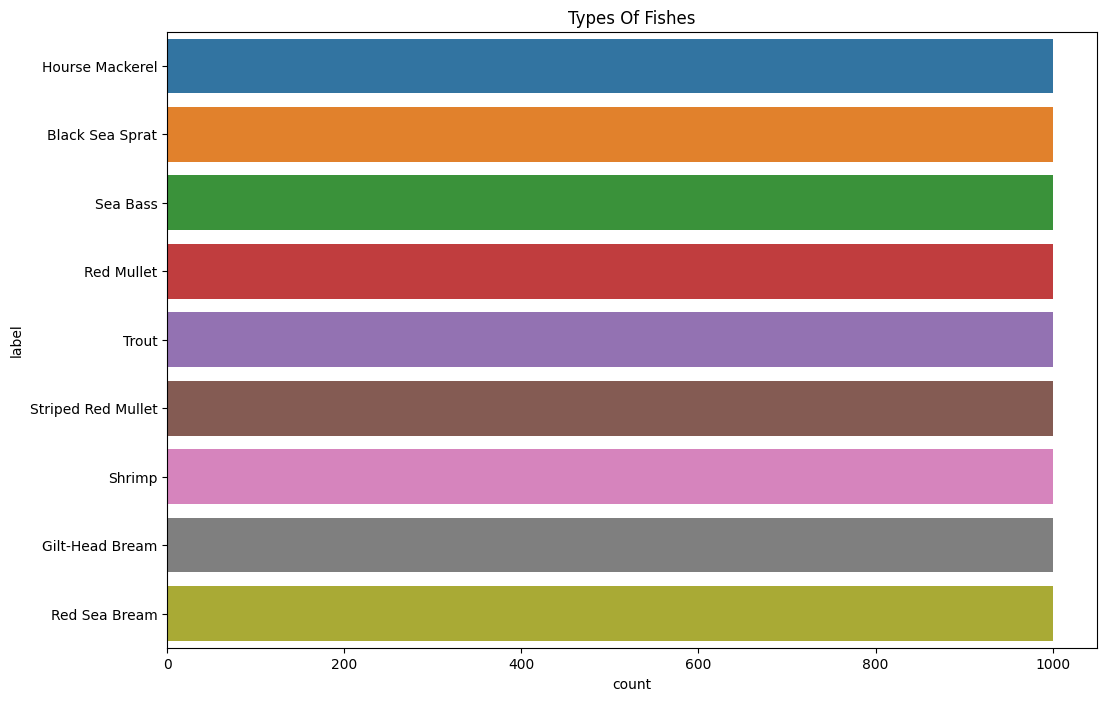

In [30]:
plt.figure(figsize=(12, 8))
sns.countplot(y='label', data=data)
plt.title('Types Of Fishes')
plt.show()

Bu hücrede, veri setinde bulunan balık türlerinin dağılımı görselleştiriliyor:

- **sns.countplot**: Her balık türünün kaç örneğinin bulunduğunu gösterir.
- Grafik, veri setindeki balık türlerinin sayısını kolayca anlamak için kullanılmıştır.

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    fish_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    fish_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  
)

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


Bu hücrede, veri artırma (data augmentation) ve veri setinin eğitim/validation olarak ayrılması yapılmıştır:

- **ImageDataGenerator**: Görüntüleri ölçeklendirir, döndürür ve veri artırma işlemleri yapar.
- **train_generator**: Eğitim verilerini hazırlar (resim boyutu ve batch size ayarlanır).
- **validation_generator**: Validation verilerini ayırır.

Bu adım, modelin daha iyi genelleştirme yapmasını sağlar.

In [32]:
model = Sequential([
    Input(shape=(150, 150, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),  # Dropout katmanı eklendi
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

Bu hücrede, derin öğrenme modelinin mimarisi oluşturulmuştur:

- **Sequential**: Katmanların sırasıyla eklendiği model yapısı.
- **Flatten**: Giriş verisini düzleştirir.
- **Dense**: Tam bağlantılı katmanlar (512, 256, 128 nöronlu) ve son katman **softmax** aktivasyon fonksiyonu ile sınıflandırma yapılır.
- **Dropout**: Aşırı öğrenmeyi (overfitting) engellemek için kullanılır.

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Early stopping ekleyelim
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,  # Epoch sayısını arttıralım
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]  # Early stopping callback'ini ekleyelim
)

Epoch 1/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 352s 771ms/step - accuracy: 0.2432 - loss: 2.0282 - val_accuracy: 0.1682 - val_loss: 2.3411
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.6135
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 293s 645ms/step - accuracy: 0.3113 - loss: 1.7135 - val_accuracy: 0.2321 - val_loss: 2.5750
Epoch 4/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1875 - val_loss: 2.6584


Bu hücrede, model derlenmiş ve eğitim süreci başlatılmıştır:

- **compile**: Model, `categorical_crossentropy` kayıp fonksiyonu ve `adam` optimizer ile derlenir.
- **EarlyStopping**: Validation kaybı 3 epoch boyunca iyileşmezse eğitim durdurulur.
- **fit**: Model, 5 epoch boyunca eğitim verileriyle eğitilir ve validation verileriyle doğrulanır.

Eğitim sırasında erken durdurma ile overfitting engellenmeye çalışılır.

In [35]:
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)

113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.2306 - loss: 2.5785
Test accuracy: 0.2338888943195343


Bu hücrede, modelin validation verileri üzerindeki performansı değerlendirilmiştir:

- **evaluate**: Validation setinde modelin kaybı ve doğruluğu hesaplanır.
- **test_acc**: Modelin doğruluk değeri ekrana yazdırılır.

Bu adım, modelin eğitim sonrası ne kadar iyi genelleme yaptığını gösterir.

In [38]:
from tensorflow.keras.optimizers import Adam, RMSprop

optimizers = [Adam(learning_rate=0.001), Adam(learning_rate=0.01), RMSprop()]
for optimizer in optimizers:
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples  
 // train_generator.batch_size,
        epochs=5,  
  # Epoch sayısını artıralım
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping]  
  # Early stopping callback'ini ekleyelim
    )
    # modelin performansını değerlendirme
    test_loss, test_acc = model.evaluate(validation_generator)
    print('Optimizer:', optimizer)
    print('Test accuracy:', test_acc)

Epoch 1/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 295s 647ms/step - accuracy: 0.2218 - loss: 1.8976 - val_accuracy: 0.1551 - val_loss: 2.0838
Epoch 2/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3125 - val_loss: 1.9736
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 293s 645ms/step - accuracy: 0.2470 - loss: 1.8390 - val_accuracy: 0.1861 - val_loss: 2.0525
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 504ms/step - accuracy: 0.1743 - loss: 2.0583
Optimizer: <keras.src.optimizers.adam.Adam object at 0x7d03268f0d30>
Test accuracy: 0.1852777749300003
Epoch 1/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 295s 647ms/step - accuracy: 0.1302 - loss: 2.2018 - val_accuracy: 0.1113 - val_loss: 2.1977
Epoch 2/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0625 - val_loss: 2.1944
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 293s 645ms/step - accuracy: 0.1056 - loss: 2.1982 - val_accuracy: 0.1116 - val_loss: 2.1977
113/113 ━━━━━━━━━━━━━

Bu hücrede, farklı optimizer'lar (Adam, RMSprop) kullanılarak modelin performansı karşılaştırılmıştır:

- **optimizers**: Farklı öğrenme oranlarına sahip Adam ve RMSprop kullanılır.
- **fit**: Her optimizer için model yeniden eğitilir.
- **evaluate**: Her optimizer sonrası model validation setinde değerlendirilir.
- Sonuçlar karşılaştırılarak en iyi optimizer belirlenir.

(Doğruluk oranının bu kadar düşük olmasının sebebini anlayamadım.)

Bu hücrede, modelin tahmin sonuçları değerlendirilmektedir:

- **predict**: Validation verilerinden tahminler alınır.
- **confusion_matrix**: Gerçek ve tahmin edilen sınıflar arasındaki ilişkiler gösterilir.
- **heatmap**: Karışıklık matrisi görselleştirilir.
- **classification_report**: Precision, recall ve F1-score gibi metrikler yazdırılır.

Bu adım, modelin hangi sınıflarda ne kadar başarılı olduğunu gösterir.

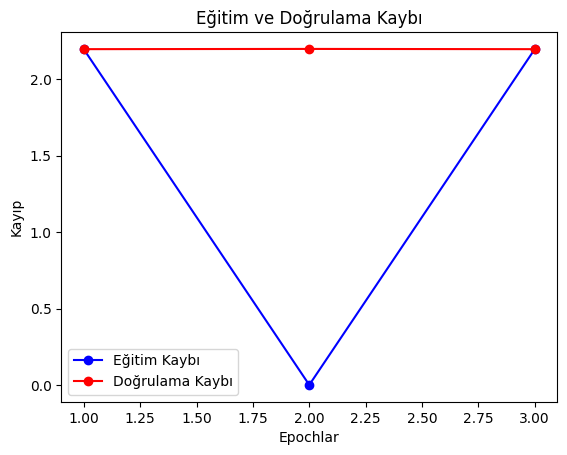

In [40]:
# Eğitim sürecindeki kayıp ve doğruluk değerlerini al
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  


# Epoch sayısını al
epochs = range(1, len(train_loss) + 1)

# Kayıp grafiğini çiz
plt.plot(epochs, train_loss, 'bo-', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'ro-', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochlar')  

plt.ylabel('Kayıp')
plt.legend()

plt.show()

Bu hücrede, modelin eğitim sürecindeki kayıp değerleri görselleştirilmiştir:

- **train_loss** ve **val_loss**: Eğitim ve doğrulama kayıpları elde edilir.
- **plt.plot**: Kayıp değerleri epoch sayısına göre çizilir.
- Grafik, modelin eğitim sürecindeki ilerlemeyi ve olası overfitting durumlarını görselleştirmek için kullanılır.